# Analyzing Network Identity Data and Red Team Response with Graphistry AutoML + UMAP

We find a simple model that when clustered in a 2d plane via UMAP allows fast identification of anomalous 
computer to computer connections

In [1]:
# ! pip install graphistry[ai] 

In [ ]:
import pandas as pd
import graphistry

from graphistry.features import topic_model, search_model, ModelDict

import os
from joblib import load, dump
from collections import Counter

import numpy as np
import matplotlib.pylab as plt


In [4]:
np.random.seed(137)

In [5]:
RENDER = True # set to True to render Graphistry UI inline

In [6]:
graphistry.register(api=3, protocol="https", server="hub.graphistry.com", username = os.environ['USERNAME'], password=os.environ['GRAPHISTRY_PASSWORD'])

Alert on & visualize anomalous identity events

Demo dataset: 1.6B windows events over 58 days => logins by 12K user over 14K systems
adapt to any identity system with logins. Here we subsample down to a small set of 50k events to prove out the pipeline. 

* => Can we identify accounts & computers acting anomalously? Resources being oddly accessed?
* => Can we spot the red team?
* => Operations: Identity incident alerting + identity data investigations

Community/contact for help handling bigger-than-memory & additional features

Runs on both CPU + multi-GPU
Tools: PyGraphistry[AI], DGL + PyTorch, and NVIDIA RAPIDS / umap-learn

In [7]:
# data source citation
# """A. D. Kent, "Cybersecurity Data Sources for Dynamic Network Research,"
# in Dynamic Networks in Cybersecurity, 2015.

# @InProceedings{akent-2015-enterprise-data,
#    author = {Alexander D. Kent},
#    title = {{Cybersecurity Data Sources for Dynamic Network Research}},
#    year = 2015,
#    booktitle = {Dynamic Networks in Cybersecurity},
#    month =        jun,
#    publisher = {Imperial College Press}
# }"""

# Data Loading and Munging


In [8]:
# small sample (get almost equivalent results without overheating computer over the 1.6B events in the full dataset)
df = pd.read_csv('https://gist.githubusercontent.com/silkspace/c7b50d0c03dc59f63c48d68d696958ff/raw/31d918267f86f8252d42d2e9597ba6fc03fcdac2/redteam_50k.csv', index_col=0)
df.head(5)

,time,src_domain,dst_domain,src_computer,dst_computer,auth_type,logontype,authentication_orientation,success_or_failure,RED,feats,feats2
30526246,155805,C7048$@DOM1,C7048$@DOM1,C7048,TGT,?,?,TGS,Success,0.0,C7048 TGT ? ?,C7048 TGT
5928201,37690,C15034$@DOM1,C15034$@DOM1,C15034,C467,?,?,TGS,Success,0.0,C15034 C467 ? ?,C15034 C467
21160461,116992,U2075@DOM1,U2075@DOM1,C529,C529,?,Network,LogOff,Success,0.0,C529 C529 ? Network,C529 C529
2182328,22019,C3547$@DOM1,C3547$@DOM1,C457,C457,?,Network,LogOff,Success,0.0,C457 C457 ? Network,C457 C457
28495743,145572,C567$@DOM1,C567$@DOM1,C574,C523,Kerberos,Network,LogOn,Success,0.0,C574 C523 Kerberos Network,C574 C523


In [9]:
print(df.shape) # -> 50k

(50000, 12)


In [10]:
# here are the post-facto red team events
red_team = pd.read_csv('https://gist.githubusercontent.com/silkspace/5cf5a94b9ac4b4ffe38904f20d93edb1/raw/888dabd86f88ea747cf9ff5f6c44725e21536465/redteam_labels.csv', index_col=0)
red_team['feats2'] = red_team.feats

# Modeling

Make sure you `mkdir(data)` or change path below


In [11]:
process = True  
# makes a combined feature we can use for topic modeling!
if process:
    # we create two types of models
    df['feats'] = df.src_computer + ' ' + df.dst_computer + ' ' + df.auth_type + ' ' + df.logontype
    # and one of just computer to computer 
    df['feats2'] = df.src_computer + ' ' + df.dst_computer
    ndf = df.drop_duplicates(subset=['feats'])
    ndf.to_parquet('auth-feats-one-column.parquet')
else:
    ndf = pd.read_parquet('auth-feats-one-column.parquet')
    
print(ndf.shape)

(19013, 12)


## Red Team Data 
Add it to the front of the DataFrame so we can keep track of it

In [12]:
# make a subsampled dataframe with the anom red-team data at top...so we can keep track.
# we don't need the full `df`, only the unique entries of 'feats' in `ndf` for 
# fitting a model (in a few cells below)

tdf = pd.concat([red_team.reset_index(), ndf.reset_index()])
tdf

,index,time,src_domain,src_computer,dst_computer,feats,RED,feats2,dst_domain,auth_type,logontype,authentication_orientation,success_or_failure
0,0,150885,U620@DOM1,C17693,C1003,C17693 C1003,1.0,C17693 C1003,NaN,NaN,NaN,NaN,NaN
1,1,151036,U748@DOM1,C17693,C305,C17693 C305,1.0,C17693 C305,NaN,NaN,NaN,NaN,NaN
2,2,151648,U748@DOM1,C17693,C728,C17693 C728,1.0,C17693 C728,NaN,NaN,NaN,NaN,NaN
3,3,151993,U6115@DOM1,C17693,C1173,C17693 C1173,1.0,C17693 C1173,NaN,NaN,NaN,NaN,NaN
4,4,153792,U636@DOM1,C17693,C294,C17693 C294,1.0,C17693 C294,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
19008,8463107,48263,C11843$@DOM1,C11843,C528,C11843 C528 Kerberos Network,0.0,C11843 C528,C11843$@DOM1,Kerberos,Network,LogOn,Success
19009,14394630,77937,C8470$@DOM1,C8470,C528,C8470 C528 NTLM Network,0.0,C8470 C528,C8470$@DOM1,NTLM,Network,LogOn,Success
19010,33398153,173300,C716$@DOM1,C716,C716,C716 C716 ? ?,0.0,C716 C716,C716$@DOM1,?,?,AuthMap,Success
19011,18353851,102472,U7365@DOM1,C16126,C586,C16126 C586 ? ?,0.0,C16126 C586,U7365@DOM1,?,?,TGS,Success


In [13]:
# add a fidicial index used later
tdf['node'] = range(len(tdf))

In [14]:
# total number of red team events
tdf.RED.sum()

749.0

## Enrichment

In [15]:
def get_confidences_per_cluster(g, col='RED', verbose=False):
    """
        From DBSCAN clusters, will assess how many Red Team events exist,
        assessing confidence.
        
    """
    resses = []
    df = g._nodes
    labels = df._dbscan
    cnt = Counter(labels)
    for clust, count in cnt.most_common():
        res = df[df._dbscan==clust]
        n = res.shape[0]
        n_reds = res[col].sum()
        resses.append([clust, n_reds/n, n_reds, n])
        if n_reds>0 and verbose:
            print('-'*20)
            print(f'cluster: {clust}\n   red {100*n_reds/n:.2f}% or {n_reds} out of {count}')
    conf_dict = {k[0]: k[1] for k in resses}
    confidence = [conf_dict[k] for k in df._dbscan.values]
    g._nodes['confidence'] = confidence
    conf_df = pd.DataFrame(resses, columns=['_dbscan', 'confidence', 'n_red', 'total_in_cluster'])
    conf_df = conf_df.sort_values(by='confidence', ascending=False)
    return g, conf_df
    

# The Full UMAP Pipelines
Fit a model on 'feats' column

In [16]:
# this is a convienence method for setting parameters in `g.featurize()/umap()` -- just a verbose dictionary
cyber_model = ModelDict('A topic model for computer to computer + metadata cyber auth logs', **topic_model)

cyber_model.update(dict(n_topics=32, X=['feats']))  # name the column to featurize, which we lumped into `feats`

cyber_model

_________________________________________________________________

A topic model for computer to computer + metadata cyber auth logs
_________________________________________________________________

Updated: {'n_topics': 32, 'X': ['feats']}
_________________________________________________________________



{'cardinality_threshold': 2, 'cardinality_threshold_target': 2, 'n_topics': 32, 'n_topics_target': 10, 'min_words': 1000000000.0, 'X': ['feats']}

In [17]:
%%time
process = True  # set to false after it's run for ease of speed
if process:
    # ##################################
    g = graphistry.nodes(tdf, 'node')  # two lines does the heavy lifting
    g5 = g.umap(**cyber_model).dbscan(min_dist=0.2)
    # #########################
    
    g5, cluster_confidences = get_confidences_per_cluster(g5, verbose=True)
    g5.save_search_instance('auth-feat-topic.search')
else:
    g = graphistry.bind()
    g5 = g.load_search_instance('auth-feat-topic.search')
    g5, cluster_confidences = get_confidences_per_cluster(g5)

* Ignoring target column of shape (19762, 0) in UMAP fit, as it is not one dimensionalOMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


--------------------
cluster: 3
   red 0.66% or 22.0 out of 3331
--------------------
cluster: 39
   red 0.41% or 3.0 out of 724
--------------------
cluster: 9
   red 1.15% or 3.0 out of 260
--------------------
cluster: 38
   red 0.38% or 1.0 out of 260
--------------------
cluster: 13
   red 0.43% or 1.0 out of 234
--------------------
cluster: 8
   red 95.06% or 77.0 out of 81
--------------------
cluster: 1
   red 100.00% or 53.0 out of 53
--------------------
cluster: 10
   red 91.84% or 45.0 out of 49
--------------------
cluster: 12
   red 82.61% or 38.0 out of 46
--------------------
cluster: 22
   red 95.65% or 44.0 out of 46
--------------------
cluster: 18
   red 92.11% or 35.0 out of 38
--------------------
cluster: 19
   red 82.86% or 29.0 out of 35
--------------------
cluster: 15
   red 86.67% or 26.0 out of 30
--------------------
cluster: 27
   red 92.59% or 25.0 out of 27
--------------------
cluster: 32
   red 100.00% or 27.0 out of 27
--------------------
cluster: 

## Plot Graph
Color by `confidence` and hover over `red` team histogram to see where events occur. Alternatively, color by `cluster` assignment

In [18]:
g5.name('auth topic feats no target').plot(render=RENDER)

In [19]:
# see how the model has organized features
X = g5._node_features
X

,"feats: c9990, c9994, c9997","feats: kerberos, u1, u7","feats: c528, c5252, c5281","feats: c612, c6121, c6125","feats: c2446, c2444, c24464","feats: c13713, c13130, c13134","feats: c586, c5866, c5864","feats: c467, c4674, c4667","feats: unlock, c1111, c11114","feats: c625, c6257, c6255",...,"feats: c5299, c529, c5294","feats: c16616, c16168, c16663","feats: microsoft_authentication_package_v1_0, microsoft_authentication_package_v1_, microsoft_authentication_package_v1","feats: c1065, c10658, c10652","feats: cachedinteractive, remoteinteractive, interactive","feats: c3888, c3884, u608","feats: c2327, c2323, c2727","feats: negotiate, service, c14514","feats: c8282, c8280, c8289","feats: c1964, c1968, c25685"
0,0.052992,0.050029,0.051413,0.051403,0.050019,0.061212,0.051419,0.050463,0.057304,0.051460,...,0.051392,0.063923,0.050267,0.125901,1.258763,0.052462,0.051519,0.051145,0.051962,0.054784
1,1.609871,0.050030,0.051420,0.051410,0.050016,0.091486,0.051426,0.050465,0.061034,0.051467,...,0.051399,0.069057,0.050285,0.062053,1.321739,0.053182,0.051527,0.050077,0.051972,0.057155
2,0.051975,0.050030,0.557747,0.054309,0.050016,0.070115,0.051457,0.050475,0.060911,0.051500,...,0.051429,0.068827,0.050290,0.061931,1.385945,0.053210,0.053094,0.050077,0.059695,0.057138
3,0.052089,0.050032,0.051534,0.051523,0.050023,0.069080,0.051541,0.050501,3.781985,0.051586,...,0.051511,0.074502,0.050296,0.089917,2.585125,0.052992,0.051650,0.051786,0.052132,0.056803
4,1.612539,0.050031,0.051482,0.051472,0.050016,0.070362,0.051488,0.050485,0.061027,0.051532,...,0.566014,0.069057,0.050295,0.062066,1.322035,0.053263,0.073381,0.050077,0.052059,0.057233
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19008,0.051856,22.477729,7.183005,0.051355,0.050015,0.061363,0.065023,0.050447,2.851467,0.051411,...,0.080029,1.255318,0.056317,0.056565,0.057033,0.066903,0.051468,0.054699,1.611046,0.054593
19009,0.051961,0.077069,5.711064,0.051431,0.050016,0.051497,0.069693,0.050472,0.050832,0.051490,...,0.093134,0.051501,0.055322,0.051199,1.592440,0.057984,0.051550,0.057041,3.204279,0.051984
19010,0.052328,0.050035,0.051708,0.051696,4.051562,0.051775,0.987526,0.050557,0.050983,0.051765,...,0.051682,6.652512,0.050303,0.051419,0.083564,0.052265,0.051837,0.050006,0.052377,0.054756
19011,0.052075,0.050032,0.058136,0.798598,4.051370,0.054901,7.388775,0.050498,0.052861,0.051575,...,0.057975,2.655457,0.050278,0.053364,0.053534,0.052306,0.051639,0.050021,0.052118,0.054182


<AxesSubplot:>

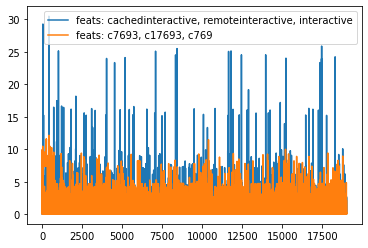

In [45]:
x = g5.get_matrix(['interactive', 'c17'])
x.plot()

## Predict | Online Mode

Once a model is fit, predict on new batches as we demonstrate here

There are two main methods

`g.transform` and `g.transform_umap` 

see help(*) on each to learn more

One may save the model as above, load it, and wrap in a FastAPI endpoint, etc, to serve in production pipelines.

In [20]:
# first sample a batch from the normal data (auth=df)
emb_normal, xp_normal, _ = g5.transform_umap(df.sample(200), None, kind='nodes', return_graph=False)
# then transform all the red team data
emb_red, xp_red, _ = g5.transform_umap(red_team, None, kind='nodes', return_graph=False)

In [21]:
# all emb's have this form
g5._node_embedding

,x,y
0,9.232593,0.724252
1,5.324008,-8.997888
2,10.624950,-0.399632
3,9.591936,-0.037859
4,13.842589,-3.487622
...,...,...
19008,10.193441,12.514707
19009,4.766062,-1.102680
19010,9.568494,-1.873951
19011,11.638880,-0.451751


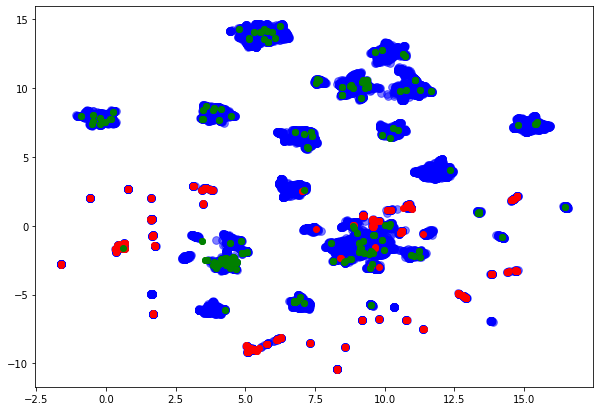

In [22]:
# scatter to see how well it does.
plt.figure(figsize=(10,7))
plt.scatter(g5._node_embedding.x, g5._node_embedding.y , c='b', s=60, alpha=0.5)  # the totality of the fit data
plt.scatter(emb_normal.x, emb_normal.y, c='g') # batch of new data
plt.scatter(emb_red.x, emb_red.y, c='r') # red labels to show good cluster seperation
plt.scatter(emb_normal.x, emb_normal.y, c='g') # batch of new data, to see if they occlude 

In [23]:
#g5.transform_umap(df.sample(200).append(red_team)).plot()

## 96% Reduction in Alerts

This indicates a huge reduction in the search space needed.

Since we have clear cluster assignments along with (post facto) confidences of known anomalous activity, we can reduce the search space on new events (gotten via Kafka, Splunk, etc)

In [24]:
# percent of RED team labels we get with 10% confidence or above
p = cluster_confidences[cluster_confidences.confidence>0.1].n_red.sum()/cluster_confidences[cluster_confidences.confidence>0.1].total_in_cluster.sum()
print(f'{100*p:.2f}%')

94.11%


In [25]:
# number of data points *not* to consider (and it's more if we look at df proper!)
cluster_confidences[cluster_confidences.confidence<0.1].total_in_cluster.sum()

18998

In [26]:
p = cluster_confidences[cluster_confidences.confidence<0.1].total_in_cluster.sum()/cluster_confidences.total_in_cluster.sum()
print(f'Alert Reduction {100*p:.2f}%')

Alert Reduction 96.13%


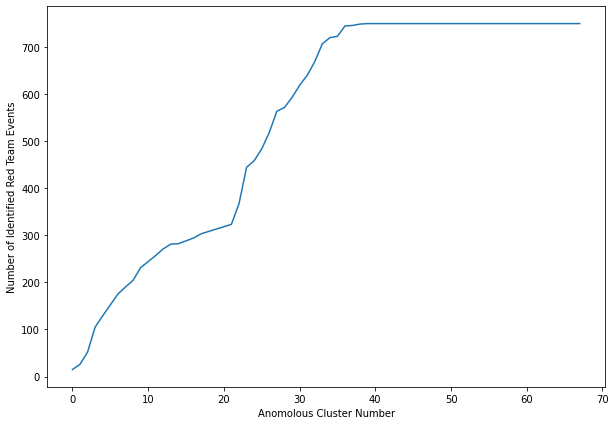

In [27]:
plt.figure(figsize=(10,7))
plt.plot(np.cumsum([k[2] for k in cluster_confidences.values]))
plt.xlabel('Anomolous Cluster Number')  # shows that we can ignore first clusters (containing most of the alerts)
plt.ylabel('Number of Identified Red Team Events')
print()

## Supervised UMAP
Here we use the RED team label to help supervise the UMAP fit. 
This might be useful once teams have actually identified RED team events 
and want to help separate clusters. 
While separation is better, the unsupervised version does well without.

In [28]:
%%time
process = True
if process:
    # ##################################  # an example of setting features explicitly, could use ModelDict 
    g = graphistry.nodes(tdf, 'node')
    g6 = g.umap(X=['feats'], y =['RED'], 
                min_words=100000, # set high to bypass sbert encoding
                cardinality_threshold=2, # set low to force topic modeling
                n_topics=32,
                use_scaler_target=None,  # keep labels unscaled
                dbscan=True)  # add dbscan here
    # ##################################
    
    g6, cluster_confidences6  = get_confidences_per_cluster(g6)
    g6.save_search_instance('auth-feat-supervised-topic.search')
else:
    g = graphistry.bind()
    g6 = g.load_search_instance('auth-feat-supervised-topic.search')
    g6, cluster_confidences6  = get_confidences_per_cluster(g6)
    

CPU times: user 3min 14s, sys: 38.6 s, total: 3min 52s
Wall time: 1min 34s


In [29]:
g6.get_matrix(target=True).astype(int)

,RED
0,1
1,1
2,1
3,1
4,1
...,...
19008,0
19009,0
19010,0
19011,0


### Plot
Color by `confidence` and hover over `red` team histogram to see where events occur. Alternatively, color by `_dbscan` assignment

In [30]:
g6.name('auth topic with supervised umap').plot(render=RENDER)

## A model of Computer-Computer features only
Here we ignore `auth_type` and `logontype` and just fit on computer to computer, unsupervised.

In [31]:
tdf['feats2']

0        C17693 C1003
1         C17693 C305
2         C17693 C728
3        C17693 C1173
4         C17693 C294
             ...     
19008     C11843 C528
19009      C8470 C528
19010       C716 C716
19011     C16126 C586
19012     C6215 C6215
Name: feats2, Length: 19762, dtype: object

In [32]:
%%time
process = True
if process:
    # #####################################
    g = graphistry.nodes(tdf, 'node')
    g7 = g.umap(X=['feats2'], #y =['RED'], 
                min_words=100000, 
                cardinality_threshold=2, 
                n_topics=32,
                use_scaler=None,
                use_scaler_target=None, 
                dbscan=True)  # add dbscan here
    # ###################################
    g7, cluster_confidences7  = get_confidences_per_cluster(g7)
    g7.save_search_instance('auth-just-ip-topic.search')
else:
    g7 = graphistry.bind().load_search_instance('auth-just-ip-topic.search')
    g7, cluster_confidences7  = get_confidences_per_cluster(g7)


* Ignoring target column of shape (19762, 0) in UMAP fit, as it is not one dimensional

CPU times: user 3min 5s, sys: 38.7 s, total: 3min 44s
Wall time: 1min 35s


### Plot
Color by `confidence` and hover over `red` team histogram to see where events occur. Alternatively, color by `cluster` assignment

In [33]:
g7.name('auth topic ips-ips only, no supervision').plot(render=RENDER)
# very similar to graph with metadata included, showing that ip-ip is strong indicator of phenomenon

In [34]:
X = g7.get_matrix()
X

,"feats2: c586, c585, c5864","feats2: c1961, c10196, c1901","feats2: c16916, c16169, c1616","feats2: c3636, c6363, c6365","feats2: c4944, c4444, c8444","feats2: c1065, c10652, c10585","feats2: c15556, c15550, c1555","feats2: c5999, c10999, c599","feats2: c17693, c6937, c3937","feats2: c8882, c8880, c8889",...,"feats2: c2890, c280, tgt","feats2: c3333, c3303, c3033","feats2: c11187, c1118, c1111","feats2: c1798, c1772, c1778","feats2: c3435, c3434, c3597","feats2: c2106, c210, c10000","feats2: c1085, c1080, c1081","feats2: c457, c222, c452","feats2: c1268, c1226, c12689","feats2: c6604, c16604, c16048"
0,0.051269,0.052370,0.059563,0.053012,0.051056,0.051073,0.059119,0.052026,7.893405,0.051389,...,0.050000,0.101370,0.059551,1.219262,0.051273,2.699579,3.244251,0.051143,0.059730,0.051639
1,0.051271,0.053484,0.066529,0.053060,0.051057,0.561800,0.067701,0.052046,7.851341,0.051392,...,0.050000,2.741899,0.068965,1.368653,1.024759,0.051145,0.108473,0.051145,0.070319,0.052000
2,0.051264,0.053257,0.064578,0.053130,0.051051,0.051067,0.065562,0.052079,7.391063,0.051386,...,0.063343,0.051320,0.066675,1.671434,0.051267,0.051138,0.097529,0.051139,0.067757,0.051922
3,0.051251,0.052477,0.065590,0.052994,0.051041,0.051057,0.063403,0.052009,7.892231,0.051369,...,0.050000,0.051307,3.263992,3.747229,0.053271,0.051127,0.192025,0.051127,0.063663,0.051661
4,0.051314,0.053518,0.066485,0.053112,1.583872,0.051108,0.067694,0.052094,7.662636,0.051438,...,0.050001,0.051372,0.069020,1.370369,0.051317,2.325817,0.109128,0.051183,0.070308,0.052039
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19008,0.065538,0.052886,0.057171,0.051741,0.566411,0.051513,0.057498,0.051674,0.064283,0.051968,...,0.051546,0.051878,4.103773,0.056866,0.071395,0.051617,0.066317,0.051617,0.058158,0.052165
19009,0.071523,0.053326,0.052552,0.052867,1.101434,0.052483,0.052288,0.052754,0.055194,0.585756,...,4.655373,0.053099,0.052118,0.052588,0.052969,0.052658,0.051738,0.052659,0.052080,0.053095
19010,0.052127,0.052384,3.672215,1.093262,0.051764,0.051788,0.051649,0.051980,0.053686,0.052330,...,0.050001,0.052224,0.051528,0.051865,0.052132,0.051912,0.070156,0.051913,0.051500,0.052221
19011,4.188590,0.052729,2.703301,1.608644,0.051619,0.051642,0.055151,0.051817,0.053484,0.052138,...,0.050001,0.052040,0.055276,0.054890,0.051957,0.051755,0.059697,0.051756,4.386074,0.052217


# Conditional Probability
Let's see if conditiona probability of computer to computer connections can give us good histograms to tease out red team nodes? This is to baseline the above UMAP models, and we find in retrospect, UMAP wins. 

The conditional graph is however useful to see aggregate behavior, and coloring by 'red' team shows topology of Infection

In [36]:
g = graphistry.edges(tdf, "src_computer", "dst_computer")

In [37]:
x='dst_computer'
given='src_computer'
cg = g.conditional_graph(x, given, kind='edges')

In [38]:
# the new edge dataframe assess conditiona prob of computer-to-computer connection
cprob = cg._edges
cprob

,src_computer,dst_computer,_probs
0,C1,C612,1.000000
1,C10,C10,0.333333
2,C10,C2997,0.333333
3,C10,C10718,0.333333
4,C100,C528,0.500000
...,...,...,...
17831,C9990,C528,0.250000
17832,C9992,C586,1.000000
17833,C9994,C9994,1.000000
17834,C9997,C586,0.500000


In [39]:
# enrich the edges dataframe with the redteam data
# since cprobs lost those labels during the function call
indx = cprob.src_computer.isin(red_team.src_computer) & cprob.dst_computer.isin(red_team.dst_computer)
cprob.loc[indx, 'red'] = 1
cprob.loc[~indx, 'red'] = 0

In [40]:
cprob

,src_computer,dst_computer,_probs,red
0,C1,C612,1.000000,0.0
1,C10,C10,0.333333,0.0
2,C10,C2997,0.333333,0.0
3,C10,C10718,0.333333,0.0
4,C100,C528,0.500000,0.0
...,...,...,...,...
17831,C9990,C528,0.250000,0.0
17832,C9992,C586,1.000000,0.0
17833,C9994,C9994,1.000000,0.0
17834,C9997,C586,0.500000,0.0


In [41]:
# add edges back to graphistry instance
cg._edges = cprob

In [42]:
# full condprob graph
cg.plot(render=RENDER)

## Learning
The conditional graph shows that most of the edge probabilities are between 4e-7 and 0.03, whose bucket contains most of the events. Thus the chances of finding the red team edges are ~ 1e-4 -- slim indeed. UMAP wins.

Likewise the transpose conditional is even worse 
with prob_detection ~ 6e-5